# Car damage case

In [1]:
# Import packages
import os
import sys
import json
import random
import numpy as np
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
import mrcnn.model as modellib 
import dataset_utils
from mrcnn.config import Config
import imgaug
import matplotlib.pyplot as plt

from mrcnn.cocoapi.PythonAPI.pycocotools.coco import COCO
from mrcnn.cocoapi.PythonAPI.pycocotools.cocoeval import COCOeval
from mrcnn.cocoapi.PythonAPI.pycocotools import mask as maskUtils

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Notebook preferences

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Model overview
Overview of assumptions, choices, and limitations.

#### Pre-processing
- Split the training dataset into 90% train and 10% validation sets
- Use image augmentation. Currently only horizontal flipping is used.
- Resizing images. To support multiple images per batch, images are resized. Aspect ratio is preserved, though. If an image is not square then zero padding is added.


#### Model and training
- Tuning parameters
- Trained model with Adam optimizer for x epochs

#### Post-processing




## Data import

#### Setting up root directory, data path  

In [4]:
# Root directory
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)  

# Directory to save images for training and validation
DATA_PATH = os.path.join(ROOT_DIR, "data/images/")

# Directory to save logs
MODEL_DIR = os.path.join(ROOT_DIR, "logs/")

# Pretrained model
PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR, "data/" "mask_rcnn_coco.h5")

#### Dataset loading and split
For training purpose we split the training set in training and evaluation. For training we use image 1 to 45, and for validation 46 to 50.

In [5]:
def print_info(dataset: dataset_utils.CustomDataset) -> None:
    """ Prints dataset info. """
    print("Image Count train: {}".format(len(dataset.image_ids)))
    print("Class Count train: {}".format(dataset.num_classes))
    for i, info in enumerate(dataset.class_info):
        print("{:3}. {:50} ".format(i, info['name']))
    

# Training data
dataset_train = dataset_utils.CustomDataset()
dataset_train.load_custom(DATA_PATH, "train")
dataset_train.prepare()
print_info(dataset=dataset_train)

# Validation data 
dataset_val = dataset_utils.CustomDataset()
dataset_val.load_custom(DATA_PATH, "val")
dataset_val.prepare()
print_info(dataset=dataset_val)

Image Count train: 44
Class Count train: 2
  0. BG                                                 
  1. scratch                                            
Image Count train: 5
Class Count train: 2
  0. BG                                                 
  1. scratch                                            


#### Image visualisation

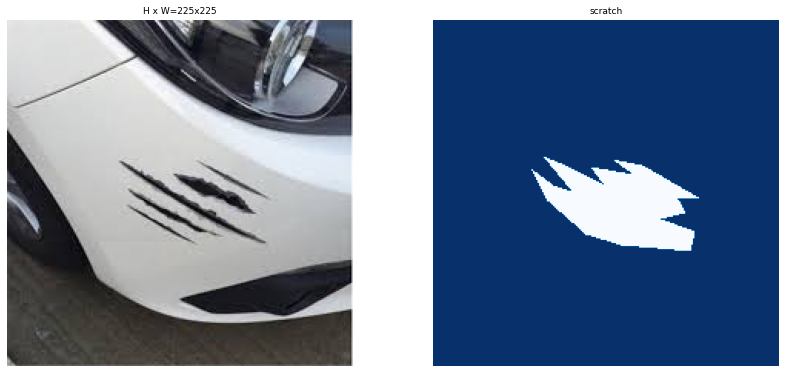

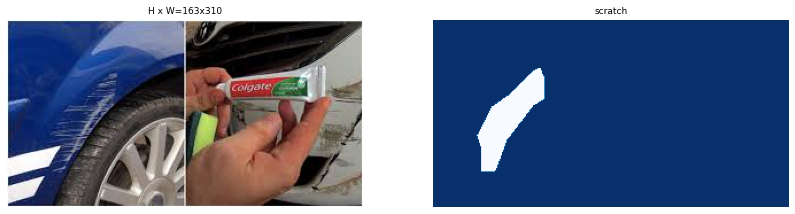

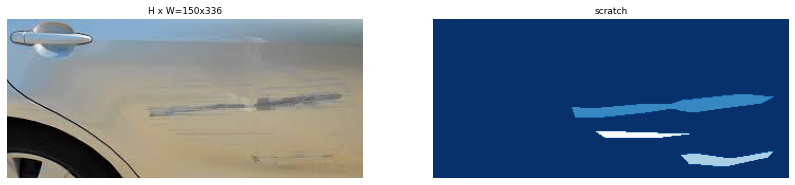

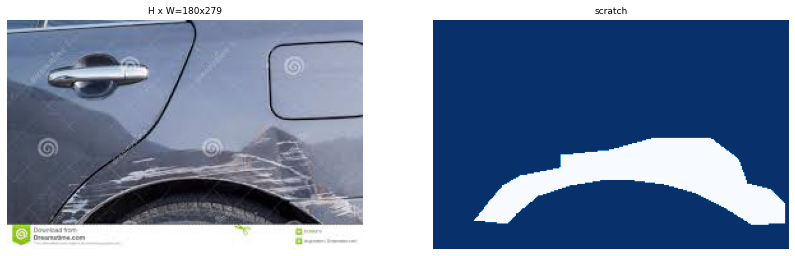

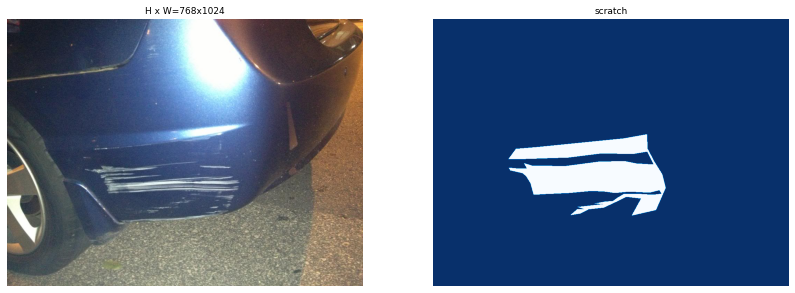

In [6]:
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

#### Create Bounding Box(BB)with annotated damage mask for a typical car image.
Compute bounding boxes from the masks.

image_id  12 /Users/jelmerkeuzenkamp/scm/damage_detection/data/images/train/image14.jpeg
image                    shape: (165, 305, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (165, 305, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   38.00000  max:  222.00000  int32


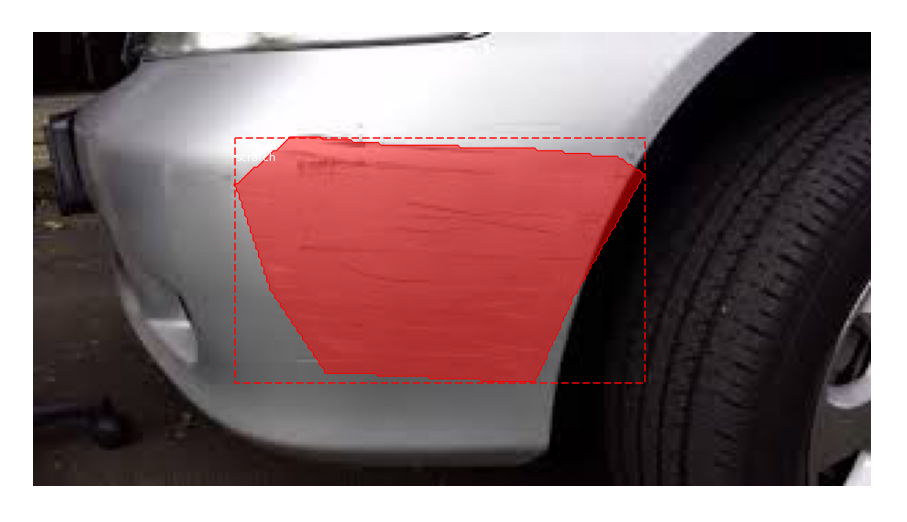

In [7]:
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

#### Damage polygon coordinates

In [8]:
anno_json = json.load(open(os.path.join(DATA_PATH, "train/via_region_data.json"),encoding="utf8"))
annotations = list(anno_json.values()) 
annotations = [a for a in annotations if a['regions']]

annotations[1]['regions']['0']['shape_attributes']
l = []
for d in annotations[1]['regions']['0']['shape_attributes'].values():
    l.append(d)
display('x co-ordinates of the damage:',l[1])    
display('y co-ordinates of the damage:',l[2])

'x co-ordinates of the damage:'

[293, 360, 349, 308, 293]

'y co-ordinates of the damage:'

[303, 330, 314, 302, 303]

## Model

#### Model configurations
Set and observe model configurations for training.

In [10]:
class DamageConfig(Config):
    """ Override base configerations for properties that need to be changed. """
    
    # Give the configuration a recognizable name
    NAME = "damage_detection"
    
    # Set number of classes 
    NUM_CLASSES = 2 # Background + scatch
    
    # Use small epoch for fast training
    STEPS_PER_EPOCH = 100
    
    # Use small images for faster training
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    
    # Use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Train on 1 GPU and batch size is 2 (GPUs * images/GPU)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

config = DamageConfig()

# Print configuration
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

#### Instantiate model
For training I used a instance on GCP's compute engine with 1 GPU and 12 GBs of memory.

In [11]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [12]:
# Load pretrained weights
model_path = PRETRAINED_MODEL_PATH
# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
model.load_weights(model_path, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

## Training
Since we're using a very small dataset, and starting from COCO trained weights, we don't need to train too long. Also, no need to train all layers, just the heads should do it. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO).

In [13]:
# Apply horizontal flipping for image augmentation
augmentation = imgaug.augmenters.Fliplr(0.5)

In [ ]:
# Train the head branches
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, # Balance between good enough fitting and execution time..
            layers='heads',
            augmentation=augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/jelmerkeuzenkamp/scm/damage_detection/logs/damage_detection20200619T1750/mask_rcnn_damage_detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_ma

/Users/jelmerkeuzenkamp/scm/damage_detection/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/jelmerkeuzenkamp/scm/damage_detection/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/jelmerkeuzenkamp/scm/damage_detection/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/Users/jelmerkeuzenkamp/scm/damage_detection/venv/lib/python3.7/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/Users/jelmerkeuzenkamp/scm/damage_detection/venv/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


## Detection

In [31]:
class InferenceConfig(Config):
    """ Override base configerations for properties that need to be changed. """
    NAME = "model_inference"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2

inference_config = InferenceConfig()

In [32]:
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

In [33]:
Get path to saved weights
model_path = os.path.join(MODEL_DIR, 
                          "damage_detection20200618T2231/mask_rcnn_damage_detection_0001.h5") # head

In [ ]:
model_path

In [35]:
model.load_weights(model_path, by_name=True)

Re-starting from epoch 1


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  262.00000  max:  736.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


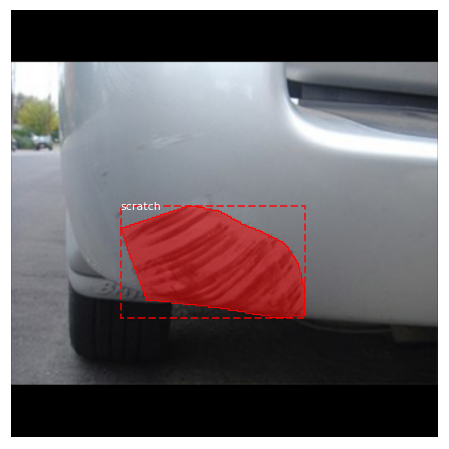

In [36]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


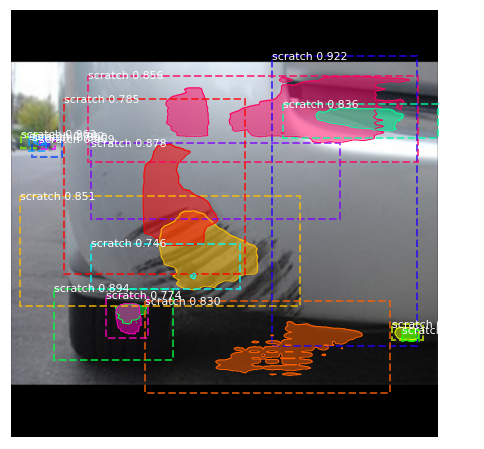

In [41]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Evaluate model. 